# Bay Wheels Trip Data Exploration
## by Moamen Abdelkawy

## Preliminary Wrangling

> Bay Wheels (formerly Ford GoBike) is a regional public bicycle sharing system in California's San Francisco Bay Area, and one of the largest in the US. This document explores a dataset containing Bay Wheels's trip data covering the period from 28 June 2017 to 31 August 2021. Data can be downloaded from [here](https://s3.amazonaws.com/baywheels-data/index.html) and data description is provided [here](https://www.lyft.com/bikes/bay-wheels/system-data).

In [1]:
# Import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import datetime
from scipy import stats
from geopy.distance import geodesic
import os
import glob

%matplotlib inline

The data is divided between numerous csv files. Using 'os' and 'glob' libraries, the code below detects all csv files. After that it is easy to concatenate these files in one dataframe.

In [2]:
# Load the dataset
folder_name = '../input/bay-wheels-trip-data-full-august-2021'
files = glob.glob(os.path.join(folder_name, "*.csv"))
bike_df = pd.concat((pd.read_csv(f, low_memory=False) for f in files), ignore_index = True)

In [3]:
# High-level overview of data shape and composition
print('Shape:{}\n'.format(bike_df.shape))
print(bike_df.info())
print()
bike_df.head()

Shape:(8316509, 24)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8316509 entries, 0 to 8316508
Data columns (total 24 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   duration_sec             float64
 1   start_time               object 
 2   end_time                 object 
 3   start_station_id         object 
 4   start_station_name       object 
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           object 
 8   end_station_name         object 
 9   end_station_latitude     float64
 10  end_station_longitude    float64
 11  bike_id                  float64
 12  user_type                object 
 13  bike_share_for_all_trip  object 
 14  ride_id                  object 
 15  rideable_type            object 
 16  started_at               object 
 17  ended_at                 object 
 18  start_lat                float64
 19  start_lng                float64
 20  end_lat                  

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,ride_id,rideable_type,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,member_casual,rental_access_method
0,68529.0,2018-12-31 20:03:11.7350,2019-01-01 15:05:21.5580,217.0,27th St at MLK Jr Way,37.817015,-122.271761,217.0,27th St at MLK Jr Way,37.817015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63587.0,2018-12-31 19:00:32.1210,2019-01-01 12:40:19.3660,NaN,NaN,37.400000,-121.940000,NaN,NaN,37.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,64169.0,2018-12-31 15:09:01.0820,2019-01-01 08:58:30.0910,NaN,NaN,37.400000,-121.940000,NaN,NaN,37.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30550.0,2018-12-31 19:26:20.7750,2019-01-01 03:55:30.7930,13.0,Commercial St at Montgomery St,37.794231,-122.402923,19.0,Post St at Kearny St,37.788975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2150.0,2018-12-31 23:59:12.0970,2019-01-01 00:35:02.1530,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,368.0,Myrtle St at Polk St,37.785434,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I'll drop all columns that are not in the official data description [here](https://www.lyft.com/bikes/bay-wheels/system-data), it's worth noting that this service changed ownership and label, this can explain the additional columns not mentioned in their official data description. 

In [4]:
# Drop all columns that are not in the official data describtion
bike_df.drop(bike_df.columns[13:], axis=1, inplace=True)

In [5]:
# Check for NaN values
bike_df.isnull().sum()

duration_sec               2521098
start_time                 2521098
end_time                   2521098
start_station_id           1261283
start_station_name         1259450
start_station_latitude     2521098
start_station_longitude    2521098
end_station_id             1317841
end_station_name           1316015
end_station_latitude       2521098
end_station_longitude      2521098
bike_id                    2521098
user_type                  2521098
dtype: int64

Almost a quarter of the data has NaN values; I'll drop these since the dataset is huge.

In [6]:
# Drop NaN values
bike_df.dropna(inplace=True)

Check for duplicates; this dataset dosn't contain ride id, which makes it tricky to find duplicated values; I will consider a value to be duplicated based on start and end time and bike id.

In [7]:
# Check for duplicates
bike_df.duplicated(subset=['start_time', 'end_time', 'bike_id']).sum()

375

In [8]:
# We have very few duplicates, dropping
bike_df.drop_duplicates(subset=['start_time', 'end_time', 'bike_id'], inplace=True)

In [9]:
# Check that there are no NaNs or duplicates
print('Number of NaN values:\n{}\n'.format(bike_df.isnull().sum()))
print('Number of duplicated values: {}'.format(bike_df.duplicated().sum()))

Number of NaN values:
duration_sec               0
start_time                 0
end_time                   0
start_station_id           0
start_station_name         0
start_station_latitude     0
start_station_longitude    0
end_station_id             0
end_station_name           0
end_station_latitude       0
end_station_longitude      0
bike_id                    0
user_type                  0
dtype: int64

Number of duplicated values: 0


Now to work on time stamps; I'll  convert `start_time` and `end_time` to datetime format; and add a column to show if the trip is in a workday or a weekend; trip duration will be converted from seconds to minutes, and the column's name will be changed. 

In [10]:
# Convert time columns to datetime format
bike_df['start_time'] = pd.to_datetime(bike_df['start_time'])
bike_df['end_time'] = pd.to_datetime(bike_df['end_time'])

# Create a weekend column as a dummy variable
bike_df['is_weekend'] = (pd.to_datetime(bike_df['start_time']).dt.weekday>=5).astype(int)

# Convert duration to minutes, change the column's name
bike_df['duration_sec'] = bike_df['duration_sec'].div(60).round(2)
bike_df.rename(columns={'duration_sec':'duration'}, inplace=True)

Next, I'll calculate the distance between start and end station for each trip, and store it in a new column `distance`; this is calculated using `geodesic` function included in `geopy` library.

In [11]:
"""    Calculate geodesic distance between two points. 
    The geodesic distance is the shortest distance on the surface of an ellipsoidal model of the earth.
   
   Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)
    
    Returns
    -------
    distance_in_km : float    """
    
def distance_calc(start, end):
        distance = geodesic(start, end).km
        return distance

In [12]:
# Calculate the distance between start and end station
# This cell takes more than 30 min to execute on Kaggle kernels
bike_df['distance'] = bike_df.apply(lambda x: distance_calc((x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude'])), axis=1)

To make my analysis easier, I'll convert `user_type` column to a dummy variable (numeric 0 and 1 datatype), and change its name to `is_subscriber`; subscribers will take the value of 1 while customers will take the value of 0.

In [13]:
# Change variable 'user_type' to numeric (0 and 1) datatype
bike_df['user_type'].replace(to_replace=['Customer', 'Subscriber'], value=[0, 1], inplace=True, limit=None, regex=False, method='pad')
bike_df.rename(columns={'user_type':'is_subscriber'}, inplace=True)

I'm interested in time trends of bike trips, differences in behavior of customers vs subscribers, and what affects the trip duration; all unnecessary columns will be dropped; I'm also sorting the dataset by `start_time`.

In [14]:
# Drop unnecessary columns
bike_df.drop(['start_station_id', 'start_station_latitude', 'start_station_longitude' ,'end_station_id', 'end_station_latitude', 'end_station_longitude', 'bike_id'], axis=1, inplace=True)

# Rearrange the dataframe
cols = ['duration', 'distance', 'start_time', 'end_time', 'is_weekend', 'is_subscriber', 'start_station_name', 'end_station_name']
bike_df = bike_df[cols]

# Sort by start_time
bike_df = bike_df.sort_values('start_time')

Finally, I'll check for noticeable outliers to ease the exploration phase.

In [15]:
# Check for outliers
bike_df.describe(percentiles = [0.25, 0.50, 0.75, 0.95, 0.99]).round(3)

,duration,distance,is_weekend,is_subscriber
count,5123983.000,5123983.000,5123983.000,5123983.000
mean,14.231,1.896,0.176,0.778
std,37.898,56.283,0.381,0.416
min,1.000,0.000,0.000,0.000
25%,5.970,0.900,0.000,1.000
50%,9.450,1.413,0.000,1.000
75%,14.750,2.168,0.000,1.000
95%,30.150,3.703,1.000,1.000
99%,86.820,4.931,1.000,1.000
max,1439.480,12809.891,1.000,1.000


Both `duration` and `distance` have extreme outliers, I'll cut these variables at the $99^{th}$ percentile.

In [16]:
# Cut outliers at 99th percentile for `duration` and `distance`
bike_df = bike_df[bike_df['duration']<=86.820]
bike_df = bike_df[bike_df['distance']<=4.931]

This the wrangled dataframe ready to be explored.

In [17]:
# high-level overview of data shape and composition after wrangling
print('Shape:{}\n'.format(bike_df.shape))
print(bike_df.info())
print()
bike_df.head()

Shape:(5022833, 8)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5022833 entries, 4674964 to 3336938
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   duration            float64       
 1   distance            float64       
 2   start_time          datetime64[ns]
 3   end_time            datetime64[ns]
 4   is_weekend          int64         
 5   is_subscriber       int64         
 6   start_station_name  object        
 7   end_station_name    object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 344.9+ MB
None



,duration,distance,start_time,end_time,is_weekend,is_subscriber,start_station_name,end_station_name
4674964,7.07,1.072791,2017-06-28 09:47:36.347,2017-06-28 09:54:41.187,0,1,Montgomery St BART Station (Market St at 2nd St),2nd St at S Park St
4674965,6.10,0.243400,2017-06-28 09:47:41.664,2017-06-28 09:53:47.715,0,1,Market St at 10th St,S Van Ness Ave at Market St
4674966,3.13,0.702203,2017-06-28 09:49:46.377,2017-06-28 09:52:55.338,0,1,Howard St at 2nd St,2nd St at S Park St
4674959,20.02,2.608357,2017-06-28 09:50:59.175,2017-06-28 10:11:00.359,0,1,Berry St at 4th St,Broadway at Battery St
4674963,7.18,0.923270,2017-06-28 09:56:39.631,2017-06-28 10:03:51.090,0,1,3rd St at Townsend St,5th at Folsom


In [18]:
# Describtive statistics
bike_df.describe(datetime_is_numeric=True).round(3)

,duration,distance,start_time,end_time,is_weekend,is_subscriber
count,5022833.000,5022833.000,5022833,5022833,5022833.000,5022833.000
mean,11.563,1.609,2019-01-04 13:50:54.510809856,2019-01-04 14:02:28.765995264,0.174,0.784
min,1.000,0.000,2017-06-28 09:47:36.347000,2017-06-28 09:52:55.338000,0.000,0.000
25%,5.900,0.900,2018-06-23 11:42:15.784000,2018-06-23 11:57:17.112999936,0.000,1.000
50%,9.300,1.406,2019-02-01 09:00:37.976999936,2019-02-01 09:10:32.777999872,0.000,1.000
75%,14.320,2.136,2019-08-07 19:30:45.822000128,2019-08-07 19:40:48.524999936,0.000,1.000
max,86.820,4.931,2020-04-01 23:57:39,2020-04-02 00:03:22,1.000,1.000
std,9.119,0.964,NaN,NaN,0.379,0.411


In [19]:
# Save this wrangled dataframe to csv file
# bike_df.to_csv('bay_wheels_data_wrangled.csv', index=False)

### What is the structure of your dataset?

> There are 5,022,833 trips in the dataset with 8 features:
- Trip duration (minutes)
- Distance between start and end station (km)
- Trip start time (datetime format)
- Trip end time (datetime format)
- Is it a weekend? (dummy variable)
- User type (subscriber or customer) (dummy variable)
- Start station name
- End station name

Variables `distance` and `duration` are numerical by nature, while `start_station_name` and `end_station_name` are nominal by nature. Rest of the variables are either in `datetime` or `dummy` formats.

### What is/are the main feature(s) of interest in your dataset?

> I'm interested in time trends of bike trips, this will demonstrate the growth of bicycle sharing systems. I'm also interested in differences in behavior of customers vs subscribers, and what affects the trip `duration`.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Since `start_time` and `end_time` are in datetime format, they will be the basis of my time trend analysis. As for trip duration, I expect that it depends on `distance`, whether the user `is_subscriber`, and if the day `is_weekend`. Differences in distributions between customers and subscribers will highlight the behavior pattern of each group.

## Univariate Exploration

I'll start by looking at the distribution of `duration`, one of our the main points of interest.

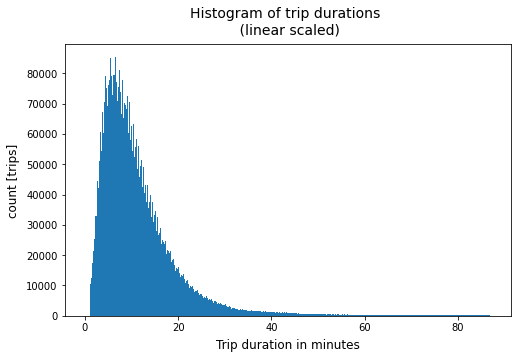

In [20]:
# Plot a histogram of the "duration" column
plt.figure(figsize=[8, 5])
bins = np.arange(0, bike_df['duration'].max()+0.2, 0.2)
plt.hist(data = bike_df, x = 'duration', bins=bins);
plt.title('Histogram of trip durations \n (linear scaled)', fontsize=14, y=1.015)
plt.xlabel('Trip duration in minutes', labelpad=6, fontsize=12)
plt.ylabel('count [trips]', labelpad=6, fontsize=12)
plt.show()

The distribution is right-skewed. I'll use a log scale on the x-axis to see id the distribution is log-normal. Since most of the data falls under a duration of 30 minutes, I'm applying a limit on the x-axis as well.

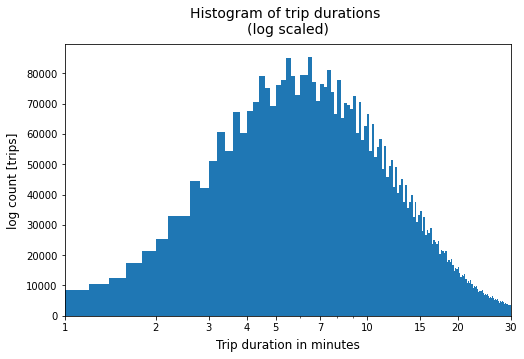

In [21]:
# Apply log scale to the x-axis, increase bin size
plt.figure(figsize=[8, 5])
bins = np.arange(0, 100, 0.2)
ticks = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 85]
labels = ['{}'.format(v) for v in ticks]
plt.hist(data = bike_df, x = 'duration', bins=bins);
plt.xscale('log')
plt.xticks(ticks, labels);
plt.xlim((1,30));
plt.title('Histogram of trip durations \n(log scaled)', fontsize=14, y=1.015)
plt.xlabel('Trip duration in minutes', labelpad=6, fontsize=12)
plt.ylabel('log count [trips]', labelpad=6, fontsize=12)
plt.show()

The distribution is close to normal but with a rough shape. It can be smoothed by increasing the bin size but this will hide some information.

Next, I'll have a look at the distribution of 'distance'. It's important to remember that this is the distance between the start and end stations, this is not necessarily the actual distance covered in the trip. This is very apparent in the amount of `zero` values in that variable, indicating a round trip.  

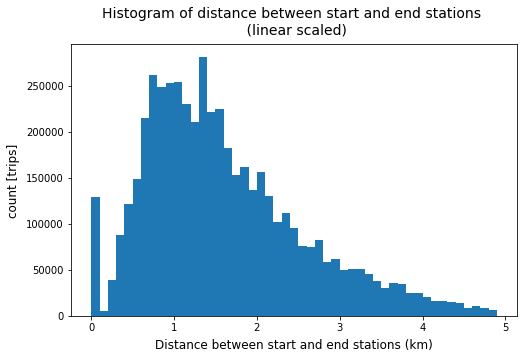

In [22]:
# Linear-scaled histogram of the "distance" column
plt.figure(figsize=[8, 5])
bins = np.arange(0, 5, 0.1)
plt.hist(data = bike_df, x = 'distance', bins=bins);
plt.title('Histogram of distance between start and end stations \n (linear scaled)', fontsize=14, y=1.015)
plt.xlabel('Distance between start and end stations (km)', labelpad=6, fontsize=12)
plt.ylabel('count [trips]', labelpad=6, fontsize=12)
plt.show()

The distribution is right-skewed indicating that in most cases, the distance between start and end stations is less than 3 kilometers, but we have trips stretching to the right with longer distances. Since distance = 0 has enough frequency to consider it an important data point, I'll apply a symmetrical log transformation on the x-axis to avoid losing this value. 

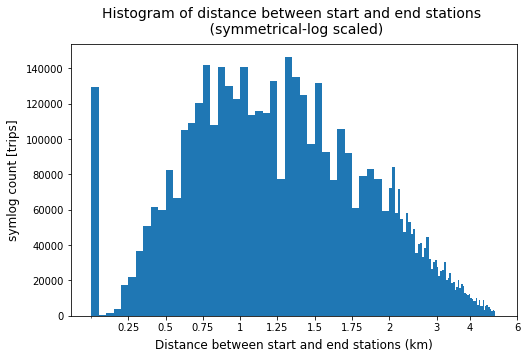

In [23]:
# Applying symmertrical log scale (a lot of data = 0)
plt.figure(figsize=[8, 5])
bins = np.arange(0, 5, 0.05)
ticks = [0.25, 0.50, 0.75, 1, 1.25, 1.5, 1.75, 2, 3, 4, 6]
labels = ['{}'.format(v) for v in ticks]
plt.hist(data = bike_df, x = 'distance', bins=bins);
plt.xscale('symlog')
plt.xticks(ticks, labels)
plt.title('Histogram of distance between start and end stations \n (symmetrical-log scaled)', fontsize=14, y=1.015)
plt.xlabel('Distance between start and end stations (km)', labelpad=6, fontsize=12)
plt.ylabel('symlog count [trips]', labelpad=6, fontsize=12)
plt.show()

This is a multimodal distribution with the most prominent mode (the major mode) at 1.3 km and many minor modes. This means that `distance` does not follow a normal distribution behavior. It can also indicate that this variable includes several patterns of response.

Now to start my time trend analysis. I'll start by visualizing number of trips per year. 

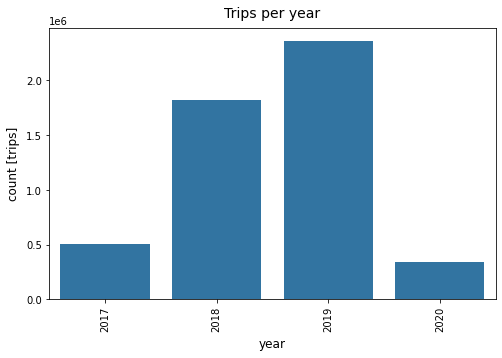

In [24]:
# Bike rides per year
# Note that the data only covers 3 months from 2020
rcParams['figure.figsize'] = 8,5
base_color = sns.color_palette()[0]
sns.countplot(data=bike_df, x=bike_df['start_time'].dt.to_period('Y'), color = base_color);
plt.title('Trips per year', fontsize=14, y=1.015)
plt.xlabel('year', labelpad=6, fontsize=12)
plt.ylabel('count [trips]', labelpad=6, fontsize=12)
# Use xticks to rotate the category labels (not axes) counter-clockwise
plt.xticks(rotation=90);

There is a clear growth between 2017-2019, though the growth rate is decreasing. It's important to remember that our dataset covers only the first quarter of 2020. Maybe it's better to check the number of trips per month instead.

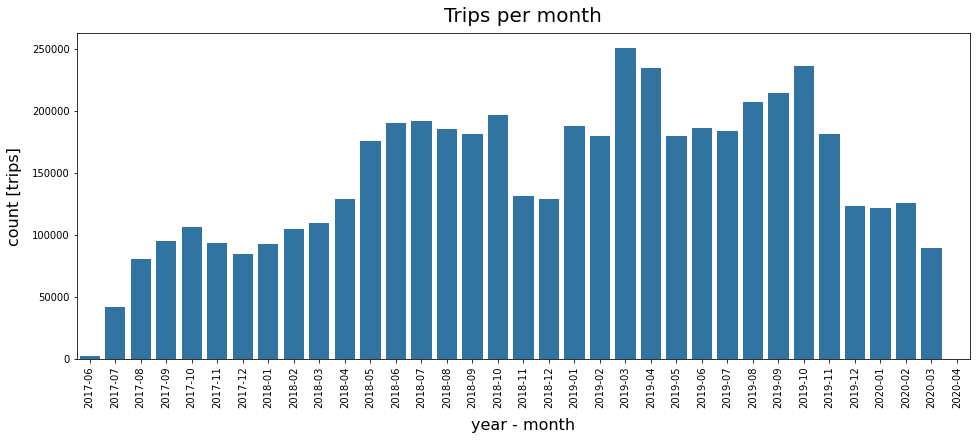

In [25]:
# bike rides per month
# Note that this depends on season
# Note that coronavirus measures started at 25 feb 2020
rcParams['figure.figsize'] = 16,6
base_color = sns.color_palette()[0]
sns.countplot(data=bike_df, x=bike_df['start_time'].dt.to_period('M'), color = base_color);
plt.title('Trips per month', fontsize=20, y=1.015)
plt.xlabel('year - month', labelpad=10, fontsize=16)
plt.ylabel('count [trips]', labelpad=10, fontsize=16)
# Use xticks to rotate the category labels (not axes) counter-clockwise
plt.xticks(rotation=90);

It is clear that the number of monthly trips is affected heavily by the season. After taking that into consideration, there is a clear growth until the last quarter of 2019. Why there is a stalemate after that requires further investigation.

Now, I'll check for the days and hours in which the bike sharing demand is peaking.

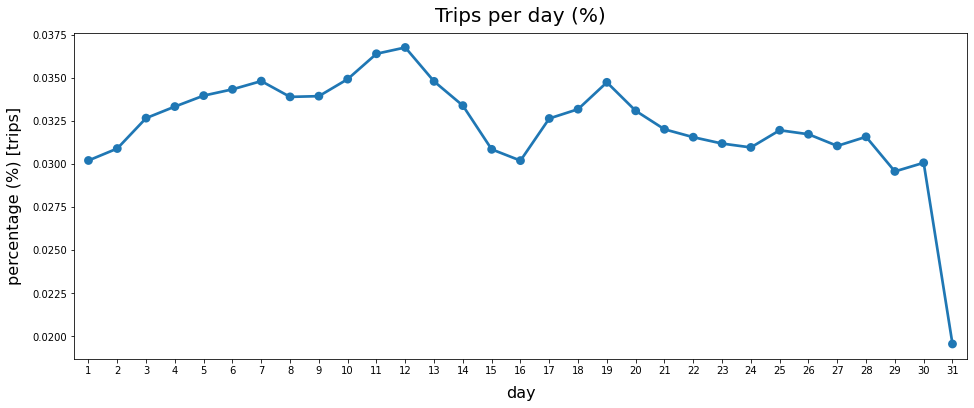

In [26]:
# Days with most trips
trips_per_day = (bike_df['start_time'].dt.day.value_counts().sort_index())/bike_df.shape[0]
# Point plot for daily rides
rcParams['figure.figsize'] = 16,6
sns.pointplot(x=trips_per_day.index, y=trips_per_day.values, color = base_color);
plt.title('Trips per day (%)', fontsize=20, y=1.015)
plt.xlabel('day', labelpad=10, fontsize=16)
plt.ylabel('percentage (%) [trips]', labelpad=10, fontsize=16);

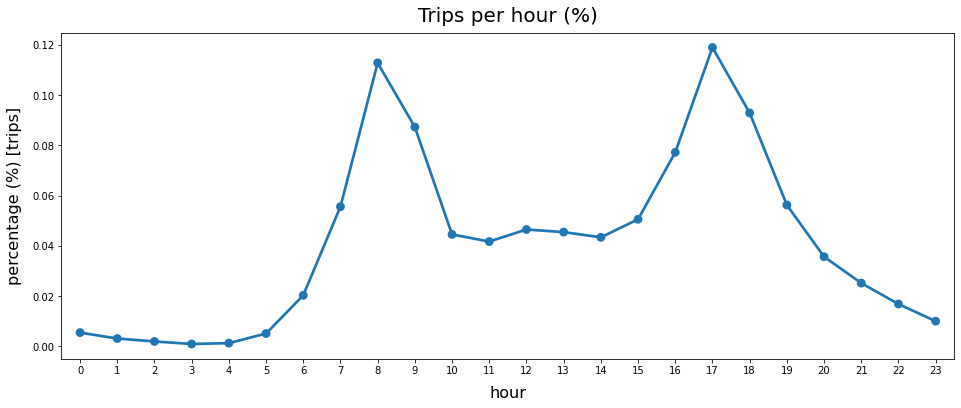

In [27]:
# Hours with most trips
trips_per_hour = (bike_df['start_time'].dt.hour.value_counts().sort_index())/bike_df.shape[0]
# Point plot for hourly rides
sns.pointplot(x=trips_per_hour.index, y=trips_per_hour.values, color = base_color);
plt.title('Trips per hour (%)', fontsize=20, y=1.015)
plt.xlabel('hour', labelpad=10, fontsize=16)
plt.ylabel('percentage (%) [trips]', labelpad=10, fontsize=16);

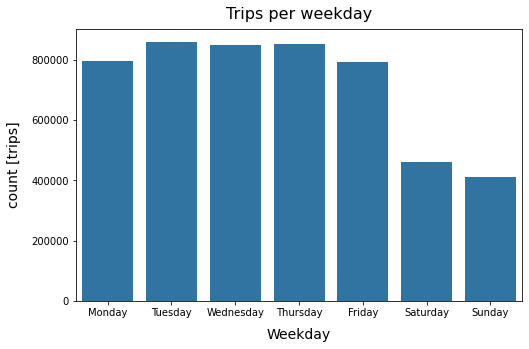

In [28]:
# Bike rides per weekday
rcParams['figure.figsize'] = 8,5
base_color = sns.color_palette()[0]
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=bike_df, x=bike_df['start_time'].dt.day_name(), order=weekday, color=base_color)
plt.title('Trips per weekday', fontsize=16, y=1.015)
plt.xlabel('Weekday', labelpad=10, fontsize=14)
plt.ylabel('count [trips]', labelpad=10, fontsize=14);

During the month, demand is the highest on $11^{th}$ - $12^{th}$, followed by $7^{th}$ and $19^{th}$. During the day, the rush hours are between 8-9 am, and 5-6 pm. As expected, demand drops significantly on weekends, and slightly on Friday and Monday.

Now to study the categorical variables. First, I'll check `is_subscriber`.

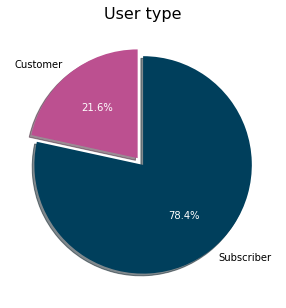

In [29]:
# Percentage of users between subscribers and customers
# rare chance for a pie chart
# plotting the pie chart
_, _, autotexts = plt.pie(bike_df['is_subscriber'].value_counts(), labels = ['Subscriber', 'Customer'], 
        colors=['#003f5c', '#bc5090'], startangle = 90, counterclock = False, shadow = True, 
        explode = (0, 0.08), radius = 1.0, autopct = '%1.1f%%')
# Change autopct text color to be white
for ins in autotexts:
    ins.set_color('white')
# Set plot title
plt.title('User type', fontsize=16, y=1.015)
plt.rcParams['font.size'] = 16
# showing the plot
plt.show()

The graph is clear, most users of Bay Wheels are subscribers. This is a rare chance to use the pie chart effectively. 

Next, I want to investigate the most popular start and end stations, are they the same or different. 

In [30]:
# Exploring most popular stations
popular_start_stations = bike_df['start_station_name'].value_counts()[:20]
popular_end_stations = bike_df['end_station_name'].value_counts()[:20]

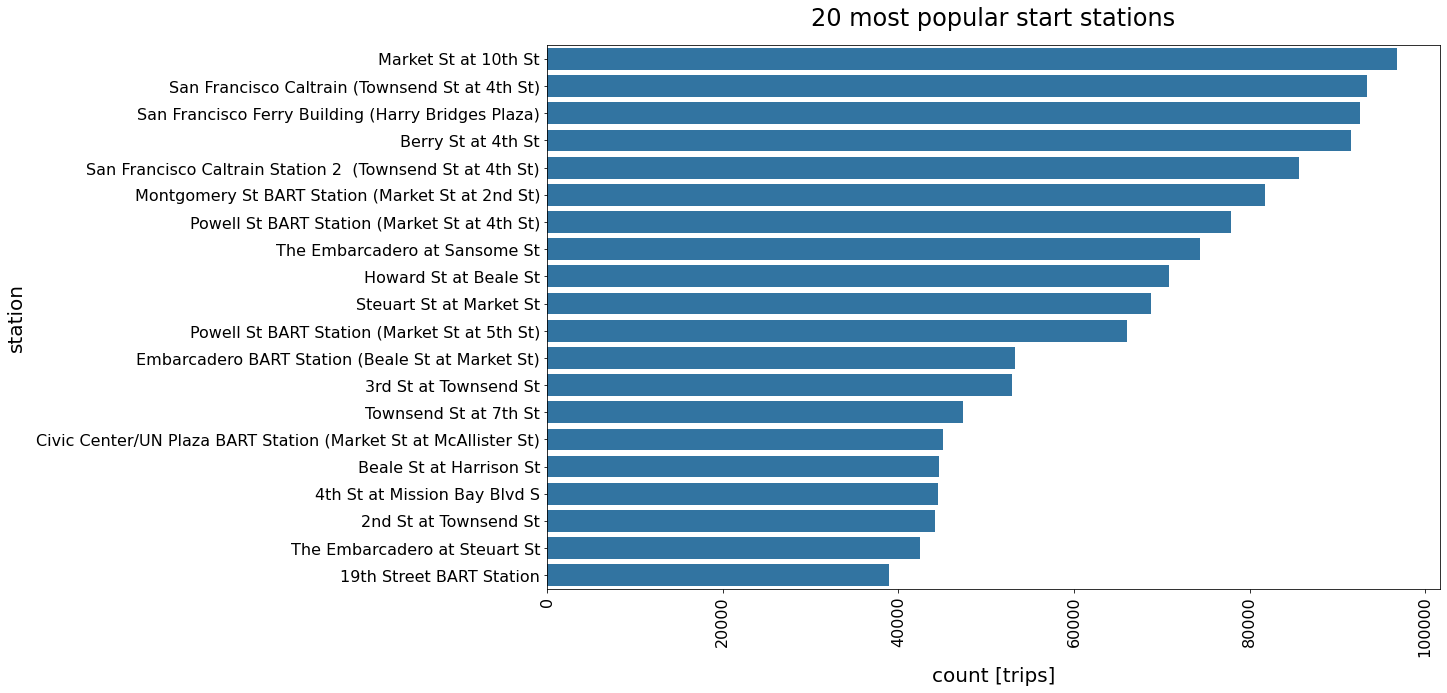

In [31]:
# 20 most popular start stations
rcParams['figure.figsize'] = 16,10
base_color = sns.color_palette()[0]
sns.barplot(x=popular_start_stations, y=popular_start_stations.index, color=base_color)
plt.title('20 most popular start stations', fontsize=24, y=1.025)
plt.xlabel('count [trips]', labelpad=10, fontsize=20)
plt.ylabel('station', labelpad=10, fontsize=20)
# Use xticks to rotate the category labels (not axes) counter-clockwise
plt.xticks(rotation=90);

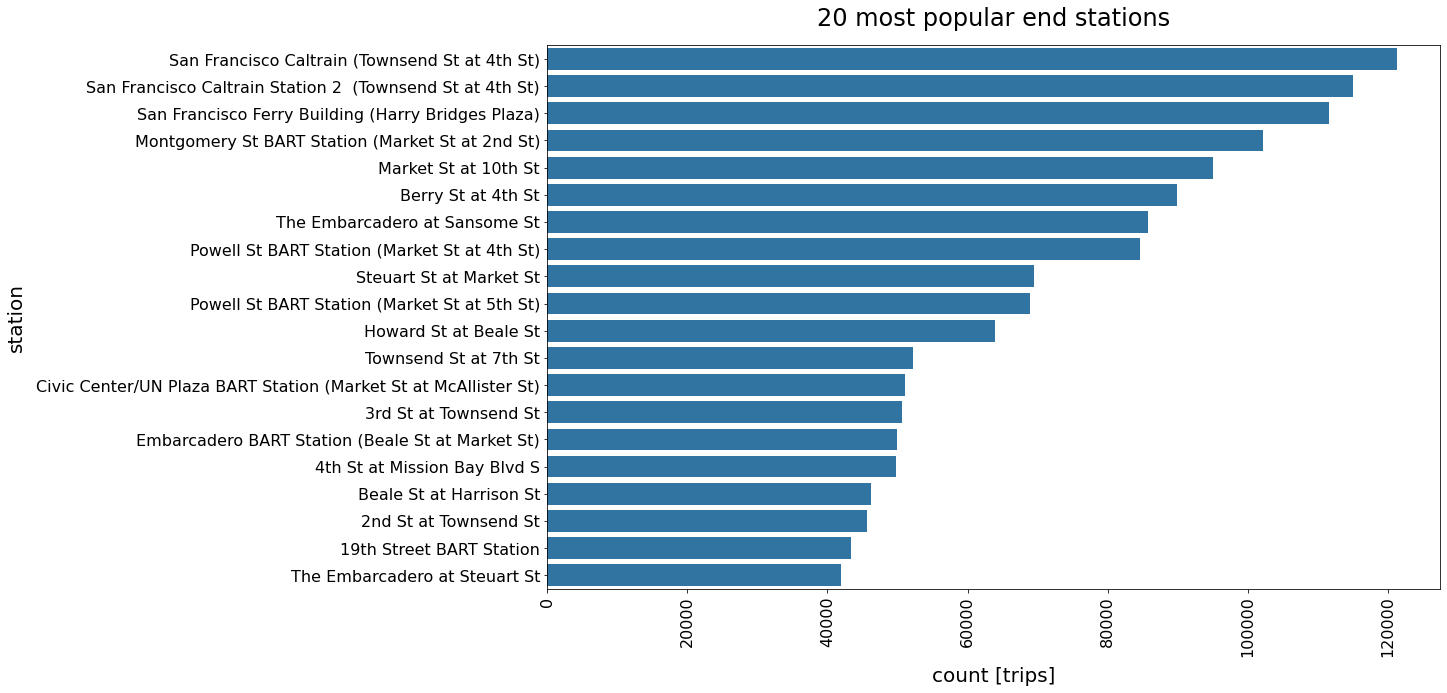

In [32]:
# 20 most popular end stations
rcParams['figure.figsize'] = 16,10
base_color = sns.color_palette()[0]
sns.barplot(x=popular_end_stations, y=popular_end_stations.index, color=base_color)
plt.title('20 most popular end stations', fontsize=24, y=1.025)
plt.xlabel('count [trips]', labelpad=10, fontsize=20)
plt.ylabel('station', labelpad=10, fontsize=20)
# Use xticks to rotate the category labels (not axes) counter-clockwise
plt.xticks(rotation=90);

In [33]:
# Popular start stations that are in popular end stations
popular_start_stations.isin(popular_end_stations).mean()

0.0

It seems that popular start and end stations are entirely different. This requires special care to keep the popular start stations stocked with bikes, while relocating the excess bikes at the popular end stations.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The distribution of `duration` is heavily right-skewed. After applying the log transformation and setting a limit on the x-axis, the distribution became roughly normal.

> As for `distance`, the distribution is right-skewed with many observations at zero value. After applying the symmetrical log transformation; the distribution became multimodal, with the most prominent mode (the major mode) at 1.3 km, and multiple minor modes. This means that `distance` does not follow a normal distribution behavior. It can also indicate that this variable includes several patterns of response.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> During the wrangling phase, I calculated the distance between the start and end stations and stored it in the `distance` column; I also added a dummy variable, `is_weekend`, to indicate whether it's a workday or weekend. To make my analysis easier, I converter the user type variable to a dummy variable, `is_subscriber`; and changed the `start_date` and `end_date` variables to a datetime format. Finally, since `duration` and `distance` variables had extreme outliers, I cut them at the $99^{th}$ percentile. 

## Bivariate Exploration

I'll start by calculating the correlation matrix of the dataset, and visualize it with a heatmap.

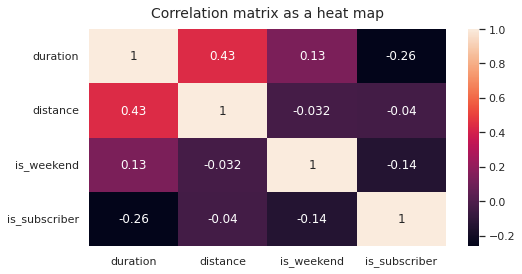

In [34]:
# Check for linear correlation

corr_df = bike_df.corr()
sns.set(rc={'figure.figsize':(8,4)})
sns.heatmap(corr_df, annot=True)
plt.title('Correlation matrix as a heat map', fontsize=14, y=1.025)
plt.show()

Looking at our main variable of interest, `duration`; it seems it has moderate linear correlation with `distance`; weak linear correlation with user type; and very weak linear correlation with weekday.

I'll explore each of these relations further, starting of `duration` vs `distance`.

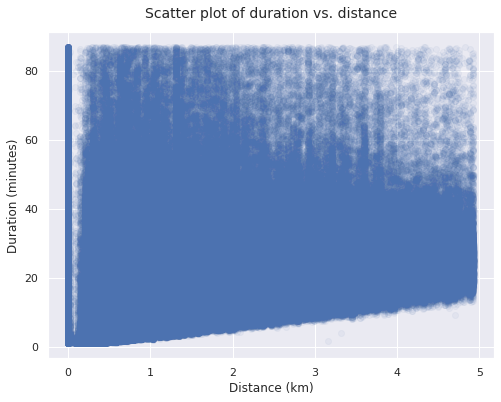

In [35]:
# Scatter plot of duration vs. distance
plt.figure(figsize = [8, 6])
plt.scatter(data = bike_df, x ='distance' , y = 'duration', alpha = 1/20)
plt.title('Scatter plot of duration vs. distance', fontsize=14, y=1.025)
plt.xlabel('Distance (km)')
plt.ylabel('Duration (minutes)')
plt.show()

Using a scatter plot with this amount of data is not a good choice, it's better to use a density heatmap or take a sample. Still, there is something to take away from this plot; this cone shape is an indication for heteroskedasticity, which weakens any regression analysis.

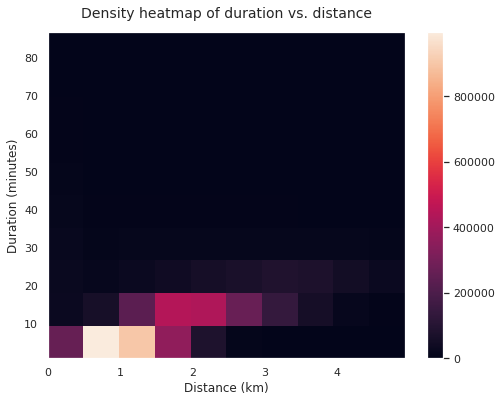

In [36]:
# density heatmap of duration vs. distance
plt.figure(figsize = [8, 6])
plt.hist2d(data = bike_df, x ='distance' , y = 'duration')
plt.title('Density heatmap of duration vs. distance', fontsize=14, y=1.025)
plt.xlabel('Distance (km)')
plt.ylabel('Duration (minutes)')
plt.colorbar()
plt.show()

There is an obvious positive relation for durations less than 30 min, I'll investigate further. 

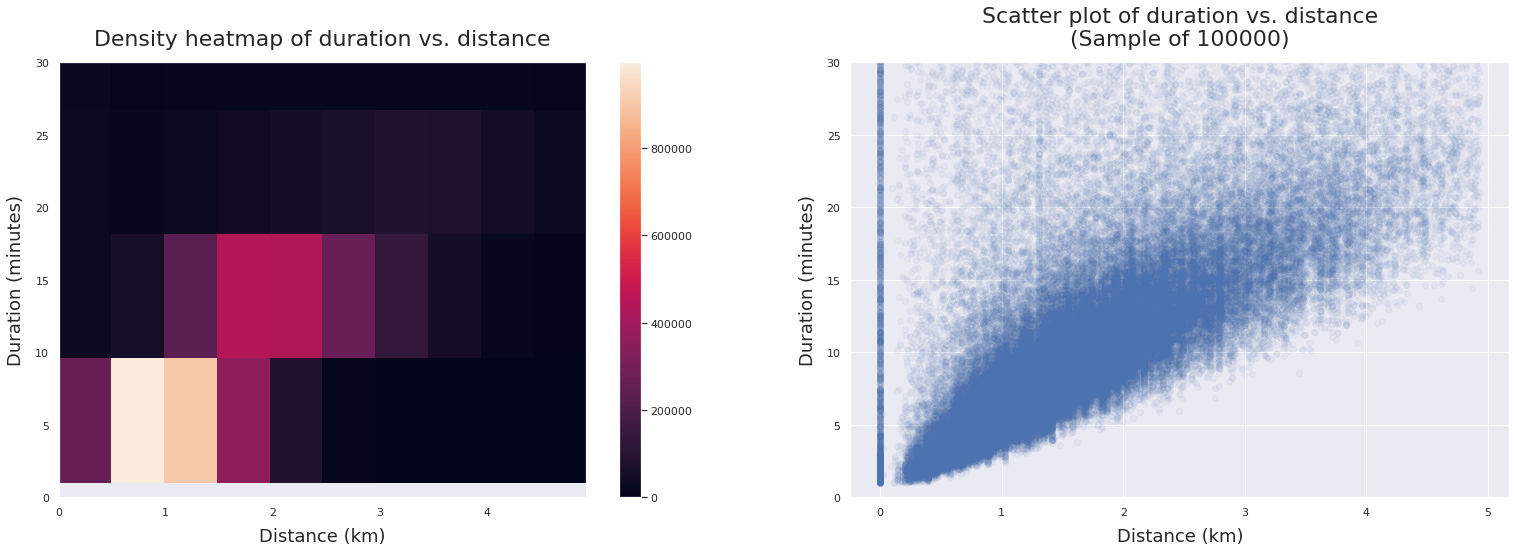

In [37]:
# further investigate the relation at duration<=30

plt.figure(figsize = [26, 8])

# Density heatmap map of duration vs distance
plt.subplot(1, 2, 1)
plt.hist2d(data = bike_df, x ='distance' , y = 'duration')
plt.ylim((0,30))
plt.title('Density heatmap of duration vs. distance', fontsize=22, y=1.025)
plt.xlabel('Distance (km)', labelpad=10, fontsize=18)
plt.ylabel('Duration (minutes)', labelpad=10, fontsize=18)
plt.colorbar()

# Scatter plot for duration vs distance, sample of 100000
plt.subplot(1, 2, 2)
sample_df = bike_df.sample(n=100000)
plt.scatter(data = sample_df, x ='distance' , y = 'duration', alpha = 1/20)
plt.ylim((0,30))
plt.title('Scatter plot of duration vs. distance\n(Sample of 100000)', fontsize=22, y=1.025)
plt.xlabel('Distance (km)', labelpad=10, fontsize=18)
plt.ylabel('Duration (minutes)', labelpad=10, fontsize=18)
plt.show();

After setting a limit on the duration axis, the relation is easy to spot. If the correlation was calculated for this limit, it becomes very strong.

In [38]:
# Calculate correlation between 'distance' and 'duration'<=30
dur_less30 = bike_df['duration'] <= 30
bike_df['duration'][dur_less30].corr(bike_df['distance'])

0.7084684027198329

Now I'll move to investigate the effect of weekday on `duration`. Since, `is_weekend` is a categorical dummy variable, a boxplot or a violin plot can be used. I chose the violin since it's more useful with large datasets. 

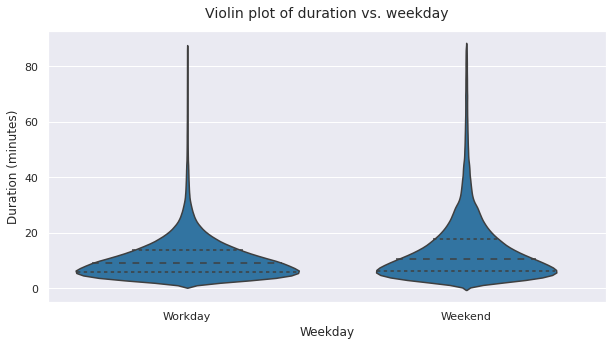

In [39]:
# Violin plot of `duration` vs `is_weekend`
# weekdays tend to have shorter trips
rcParams['figure.figsize'] = 10,5
sns.violinplot(data=bike_df, x='is_weekend', y='duration', color = base_color, inner='quartile')
ticks = [0, 1]
labels = ['Workday', 'Weekend']
plt.xticks(ticks, labels)
plt.title('Violin plot of duration vs. weekday', fontsize=14, y=1.025)
plt.xlabel('Weekday')
plt.ylabel('Duration (minutes)');

On average, bike trips tend to be longer on weekends compared to workdays; and the distribution of duration tends to have more spread on weekends.

The last variable to study its effect on `duration` is whether the user `is_subscriber` or a customer, the violin plot is still a good choice, with color encoding.

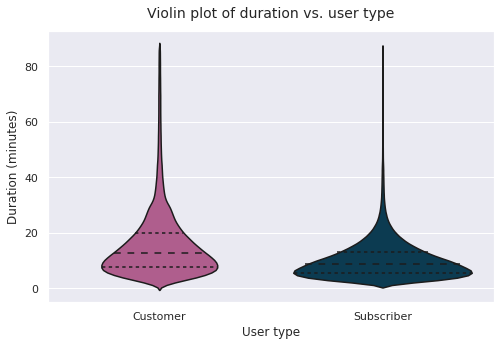

In [40]:
# Violin plot of `is_subscriber` vs `duration`
# Customers tend to vary their trip durations, subscribers typically have short trips
rcParams['figure.figsize'] = 8,5
sns.violinplot(data=bike_df, x='is_subscriber', y='duration', inner='quartile', palette=['#bc5090', '#003f5c'])
ticks = [0, 1]
labels = ['Customer', 'Subscriber']
plt.xticks(ticks, labels)
plt.title('Violin plot of duration vs. user type', fontsize=14, y=1.025)
plt.xlabel('User type')
plt.ylabel('Duration (minutes)');

It seems that customers tend to have more `duration` for their trips, their distribution also have more spread compared to subscribers.

The latter plot is the first to illustrate the difference in behavior between customers and subscribers. This will be investigated further in the following plots will via the study of time trends. 

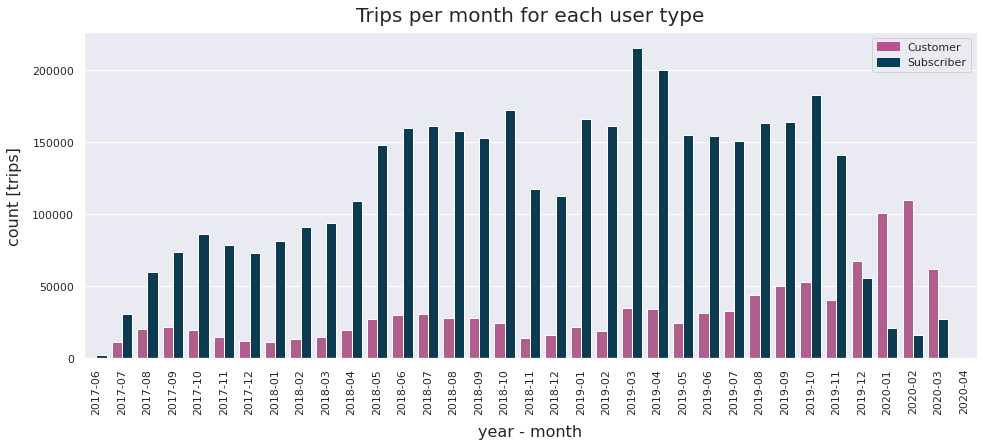

In [41]:
# Bike rides per month for each user type
# Note that this depends on season
# Note that coronavirus measures started at 25 feb 2020
rcParams['figure.figsize'] = 16,6
sns.countplot(data=bike_df, x=bike_df['start_time'].dt.to_period('M'), hue='is_subscriber', palette=['#bc5090', '#003f5c'])
plt.title('Trips per month for each user type', fontsize=20, y=1.015)
plt.xlabel('year - month', labelpad=10, fontsize=16)
plt.ylabel('count [trips]', labelpad=10, fontsize=16)
# Use xticks to rotate the category labels (not axes) counter-clockwise
plt.xticks(rotation=90)
# Creating artists specifically for adding to the legend (Proxy artists)
customer_legend = mpatches.Patch(color='#bc5090', label='Customer')
subscriber_legend = mpatches.Patch(color='#003f5c', label='Subscriber')
plt.legend(handles=[customer_legend, subscriber_legend])
plt.show();

This bar plot shows that for the most part, changes in monthly trips count tend to be similar for both user types. This pattern persists till the end of November 2019; after that date, the number of customers is, surprisingly, higher than this of subscribers. Clearly there is something wrong either in the service itself, or the subscription plans, but I don't have more leads in the dataset to follow. This can be an intriguing question in the explanatory analysis.

In [42]:
# Creating masks for user type
customer = bike_df['is_subscriber'] == 0
subscriber = bike_df['is_subscriber'] == 1

In [43]:
# Days with most trips per user type
daily_trips_customer = (bike_df.start_time[customer].dt.day.value_counts().sort_index())/bike_df[customer].shape[0]
daily_trips_subscriber = (bike_df.start_time[subscriber].dt.day.value_counts().sort_index())/bike_df[subscriber].shape[0]

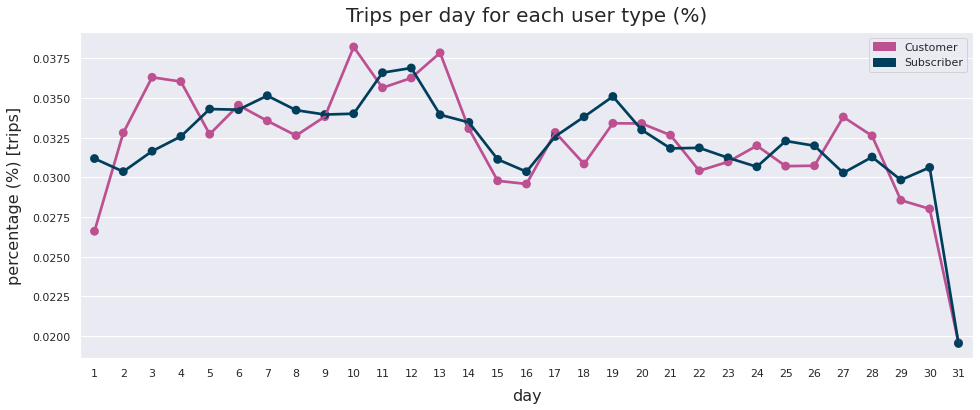

In [44]:
# Point plot for daily rides per user type
rcParams['figure.figsize'] = 16,6
fig, ax = plt.subplots()
sns.pointplot(x=daily_trips_customer.index, y=daily_trips_customer.values, color='#bc5090')
sns.pointplot(x=daily_trips_subscriber.index, y=daily_trips_subscriber.values, color='#003f5c')
plt.title('Trips per day for each user type (%)', fontsize=20, y=1.015)
plt.xlabel('day', labelpad=10, fontsize=16)
plt.ylabel('percentage (%) [trips]', labelpad=10, fontsize=16)
# Creating artists specifically for adding to the legend (Proxy artists)
customer_legend = mpatches.Patch(color='#bc5090', label='Customer')
subscriber_legend = mpatches.Patch(color='#003f5c', label='Subscriber')
plt.legend(handles=[customer_legend, subscriber_legend])
plt.show();

This point plot illustrates that; for customers, demand peaks on the $10^{th}$, $13^{th}$, $3^{rd}$, and $4^{th}$; and drops significantly on $15^{th}$-$16^{th}$; the daily trend for customers tends to be more volatile compared to subscribers; whose daily trend tend to be similar to what I found in the univariate exploration.

In [45]:
# Hours with most trips per user type
hourly_trips_customer = (bike_df.start_time[customer].dt.hour.value_counts().sort_index())/bike_df[customer].shape[0]
hourly_trips_subscriber = (bike_df.start_time[subscriber].dt.hour.value_counts().sort_index())/bike_df[subscriber].shape[0]

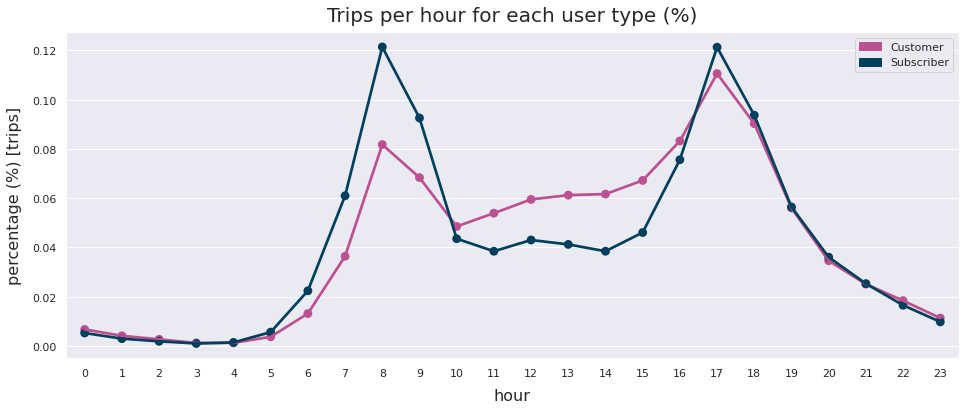

In [46]:
# Point plot for hourly rides per user type
rcParams['figure.figsize'] = 16,6
fig, ax = plt.subplots()
sns.pointplot(x=hourly_trips_customer.index, y=hourly_trips_customer.values, color='#bc5090')
sns.pointplot(x=hourly_trips_subscriber.index, y=hourly_trips_subscriber.values, color='#003f5c')
plt.title('Trips per hour for each user type (%)', fontsize=20, y=1.015)
plt.xlabel('hour', labelpad=10, fontsize=16)
plt.ylabel('percentage (%) [trips]', labelpad=10, fontsize=16)
# Creating artists specifically for adding to the legend (Proxy artists)
customer_legend = mpatches.Patch(color='#bc5090', label='Customer')
subscriber_legend = mpatches.Patch(color='#003f5c', label='Subscriber')
plt.legend(handles=[customer_legend, subscriber_legend])
plt.show();

Investigating bike trips per hour for each user type, reveals that this time subscribers demand tend to more volatile through the day; for both user types, demand peaks between 8-9 am and 5-6 pm, and drops between 10 am-3 pm; but the drop is greater for subscribers.

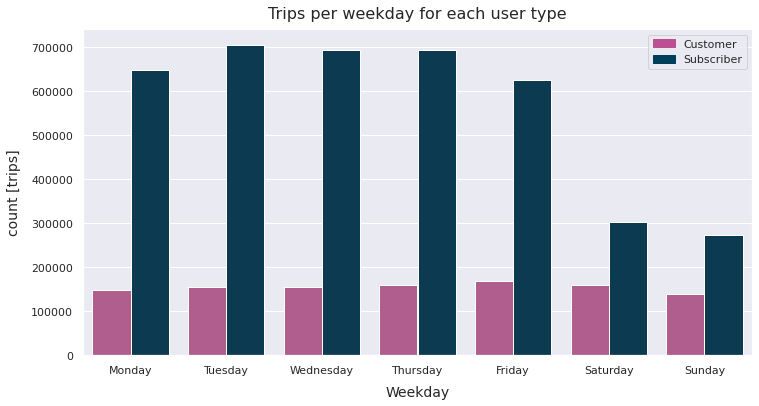

In [47]:
# Bike rides per weekday for each user type
rcParams['figure.figsize'] = 12,6
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=bike_df, x=bike_df['start_time'].dt.day_name(), hue='is_subscriber', order=weekday, palette=['#bc5090', '#003f5c'])
plt.title('Trips per weekday for each user type', fontsize=16, y=1.015)
plt.xlabel('Weekday', labelpad=10, fontsize=14)
plt.ylabel('count [trips]', labelpad=10, fontsize=14)
# Creating artists specifically for adding to the legend (Proxy artists)
customer_legend = mpatches.Patch(color='#bc5090', label='Customer')
subscriber_legend = mpatches.Patch(color='#003f5c', label='Subscriber')
plt.legend(handles=[customer_legend, subscriber_legend])
plt.show();

Customers' demand seems to be smoother across the week, while subscribers' demand drops notably on the weekends. Combining this insight with what I saw in the previous line plot leads to the conclusion that probably most subscribers use Bay Wheels to commute to and from their work; while customers use the service for varied reasons.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

There is a strong positive linear correlation between short trips `duration` (less than 30 minutes) and `distance` between start and end station; this relation becomes weaker for longer durations. On average, trips `duration` tend to be longer on weekends compared to workdays; and for customers compared to subscribers.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

Starting from December 2019, the ratio of subscribers dropped dramatically, this may be due to problems in the service itself, or the subscription plans. There are differences between customers' and subscribers' demand; peak days differ during the month, and customers' demand tend to be more volatile; while during the day, both demands have the same peak and trough hours, but subscribers' demand is more volatile; also, customers' demand seems to be smoother across the week, while subscribers' demand drops notably on the weekends.

## Multivariate Exploration

I'll start by calculating the correlation matrix for each user type, and visualize it with a heatmap. Based on what I saw in the bivariate exploration, I'll only consider short trips (`duration` <= 30 minutes).

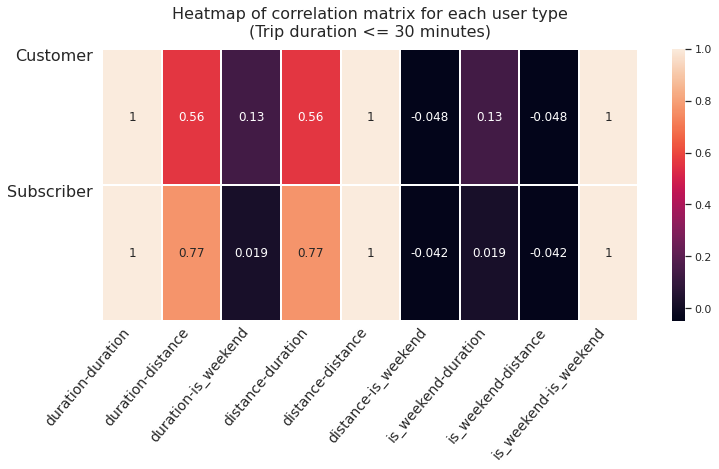

In [48]:
# Heatmap for correlations between 'duration','distance, and 'is_weekend' for each user type
rcParams['figure.figsize'] = 12,5
# Create a mask for duration <= 30 minutes
dur_less30 = bike_df['duration'] <= 30
num_cols = ['duration', 'distance', 'is_weekend']
corr_df = bike_df[num_cols][dur_less30].groupby(bike_df['is_subscriber']).corr()
sns.heatmap(corr_df.unstack(), annot=True, linewidths=1.5)
ticks = [0, 1]
labels = ['Customer', 'Subscriber']
plt.xticks(va='center_baseline', ha='right', rotation=50, fontsize=14)
plt.yticks(ticks, labels, va='top', ha='right', rotation=0, fontsize=16)
plt.title('Heatmap of correlation matrix for each user type\n(Trip duration <= 30 minutes)', fontsize=16, y=1.025)
plt.xlabel('', labelpad=10, fontsize=18)
plt.ylabel('', labelpad=10, fontsize=18)
plt.show()

The linear correlation between `duration` and `distance` is stronger for subscribers; on the other hand, there is a weak correlation between `duration` and weekday for customers, but not for subscribers. These insights are illustrated in the following plots.

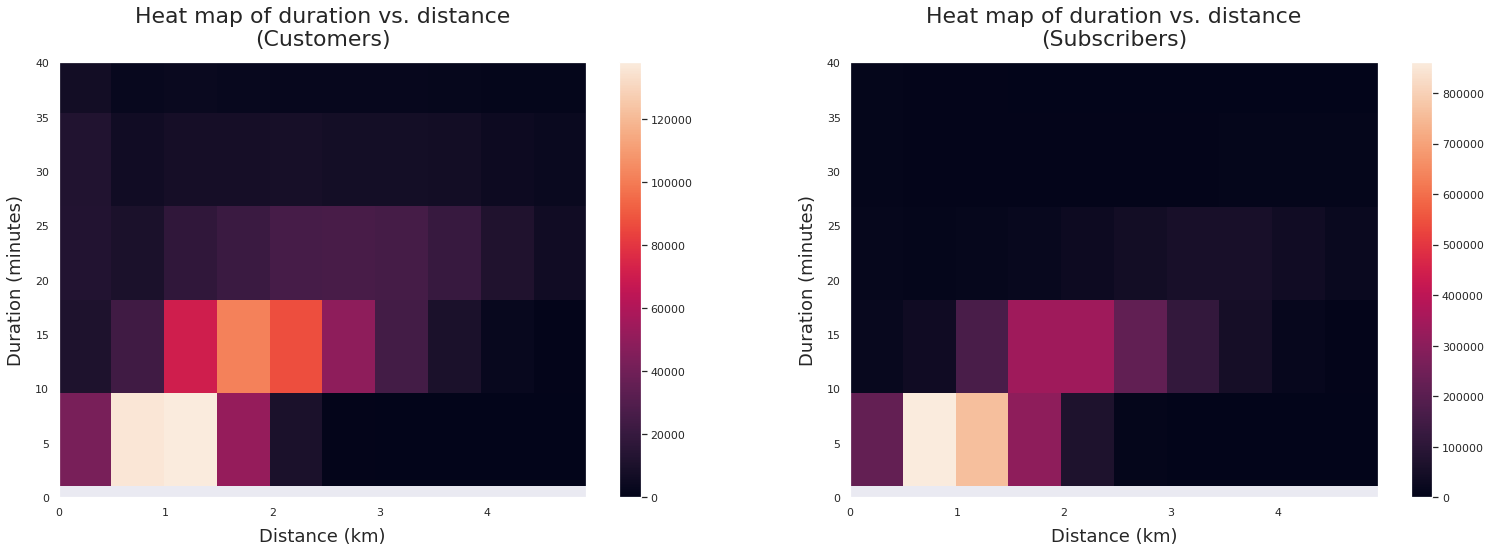

In [49]:
# density heatmap of duration vs distance for each user type
# further investigate relation at duration<=40

plt.figure(figsize = [26, 8])

# Heat map of duration vs distance for customers
plt.subplot(1, 2, 1)
plt.hist2d(data = bike_df, x =bike_df.distance[customer] , y = bike_df.duration[customer])
plt.ylim((0,40))
plt.title('Heat map of duration vs. distance\n(Customers)', fontsize=22, y=1.025)
plt.xlabel('Distance (km)', labelpad=10, fontsize=18)
plt.ylabel('Duration (minutes)', labelpad=10, fontsize=18)
plt.colorbar()

# Heat map of duration vs distance for subscribers
plt.subplot(1, 2, 2)
plt.hist2d(data = bike_df, x =bike_df.distance[subscriber], y = bike_df.duration[subscriber])
plt.ylim((0,40))
plt.title('Heat map of duration vs. distance\n(Subscribers)', fontsize=22, y=1.025)
plt.xlabel('Distance (km)', labelpad=10, fontsize=18)
plt.ylabel('Duration (minutes)', labelpad=10, fontsize=18)
plt.colorbar()
plt.show();

The `duration` values are more scattered for each distance in the case of customers, this is the reason for the weaker correlation for this user type. 

Finally, I'll explore the effect of weekday on `duration` for each user type, using a split violin plot.

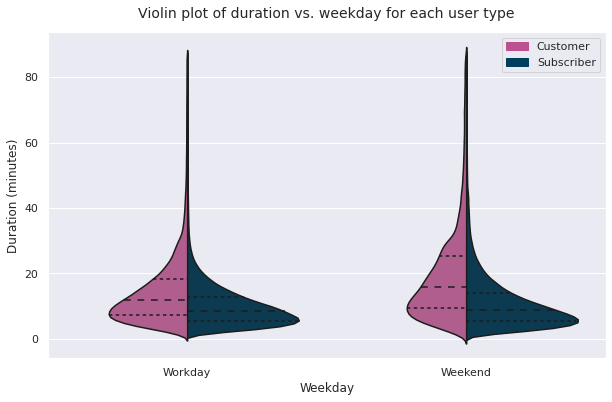

In [50]:
# Violin plot of `is_weekend` vs `duration` for each user type
rcParams['figure.figsize'] = 10,6
sns.violinplot(data=bike_df, x='is_weekend', y='duration', hue='is_subscriber', inner='quartile', palette=['#bc5090', '#003f5c'], split=True)
ticks = [0, 1]
labels = ['Workday', 'Weekend']
plt.xticks(ticks, labels)
plt.title('Violin plot of duration vs. weekday for each user type', fontsize=14, y=1.025)
plt.xlabel('Weekday')
plt.ylabel('Duration (minutes)')
# Creating artists specifically for adding to the legend (Proxy artists)
customer_legend = mpatches.Patch(color='#bc5090', label='Customer')
subscriber_legend = mpatches.Patch(color='#003f5c', label='Subscriber')
plt.legend(handles=[customer_legend, subscriber_legend])
plt.show();

As expected from what I found in the bivariate exploration, `duration` distribution has more spread on weekends for both user types; between user types, the plot shows that the median trip duration for customers is higher on all weekdays, and that customers' distribution have higher spread on all weekdays; customers tend, on average, to take longer trips, and their trips' durations vary more compared to subscribers.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

My multivariate exploration focused on studying the effect of user type on the relation I investigated earlier between `duration` vs `distance` and weekday; the linear correlation between duration and distance is stronger for subscribers, since `duration` values are less scattered for each `distance` compared to customers; as for weekdays, the median trip duration for customers is higher on all weekdays, and customers' distribution have higher spread on all weekdays.

### Were there any interesting or surprising interactions between features?

The results of my multivariate exploration of data was in line with what I found earlier during the bivariate exploration.